<a href="https://colab.research.google.com/github/GowthamKumar1626/Machine-Learning-Youtube/blob/master/Computer%20Vision/Rock_Paper_Scissor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Hello Guys Welcome to the new session**<br>
Today we will deal with rock paper scissor dataset.<br>
Have you ever faced any problem with <b>Overfitting</b>?<br>
Do you know how to solve the problem of overfitting in Image Classification task?<br>
Join with me I will show you how to deal with it...

## **Imports**

In [ ]:
%tensorflow_version 2.x. #For colab users
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)
tf.random.set_seed(42) #To make this notebook's output stable across runs

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x. #For colab users`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


## **Dataset Builder**

In [ ]:
builder = tfds.builder("rock_paper_scissors")
info = builder.info
print(info)

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    version=3.0.0,
    description='Images of hands playing rock, paper, scissor game.',
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=2892,
    splits={
        'test': 372,
        'train': 2520,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
    }""",
    redistribution_info=,
)



**About info**<br>
Each image size (300, 300, 3)<br>
No.of labels: 3<br>
No.of splits: 2 (train, test)<br>
Total no.of examples: 2892

## **Download dataset using builder**

In [ ]:
builder.download_and_prepare()

In [ ]:
(train, val, test) = tfds.load("rock_paper_scissors", split=["train", "test[:90%]", "test[90%:]"], shuffle_files=True, as_supervised=True)

Note: as_supervised=True will return Tuple with image and labels

## **Collect class names**

In [ ]:
class_names = []
for i in range(info.features['label'].num_classes):
  class_names.append(info.features['label'].int2str(i))

class_names

['rock', 'paper', 'scissors']

## **Plot one random image**

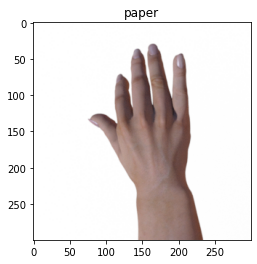

In [ ]:
image, label = next(iter(train))
_ = plt.imshow(image)
_ = plt.title(class_names[label])

In [ ]:
#Let us define some variables
BATCH_SIZE = 16
BUFFER_SIZE = 1000
NUM_EPOCHS = 5

IMAGE_SIZE = 180
NUM_CLASSES = len(class_names)

## **A sequential model for rescale and resize**

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
])

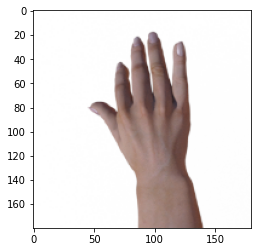

In [ ]:
resize_image = resize_and_rescale(np.expand_dims(image, axis=0))
_ = plt.imshow(resize_image[0])
plt.show()

## **Prepare train and val sets**

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

def prepare(dataset, shuffle=False, training=False):
  if training:
    dataset = dataset.map(lambda x,y: (resize_and_rescale(x, training=True), y),
                        num_parallel_calls=AUTOTUNE)
  else:
    dataset = dataset.map(lambda x,y: (resize_and_rescale(x, training=False), y),
                        num_parallel_calls=AUTOTUNE)
  if shuffle:
    dataset = dataset.shuffle(BUFFER_SIZE)
  dataset = dataset.batch(BATCH_SIZE)

  return dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
train_ds = prepare(train, shuffle=True, training=True)
val_ds = prepare(val)

## **Create our MODEL**

In [ ]:
model = tf.keras.models.Sequential([
        layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
        layers.Conv2D(64, kernel_size=3, padding="same", activation="relu"),
        layers.MaxPool2D(),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(10, activation="softmax")
])

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer = "adam",
    metrics=["accuracy"]
)

history = model.fit(
    train_ds,
    epochs = NUM_EPOCHS,
    validation_data = val_ds
)

Epoch 1/5
      1/Unknown - 0s 515us/step - loss: 2.4341 - accuracy: 0.0000e+00WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0158s vs `on_train_batch_end` time: 0.0300s). Check your callbacks.


158/158 [==============================] - 7s 42ms/step - loss: 1.1295 - accuracy: 0.8504 - val_loss: 0.7013 - val_accuracy: 0.7015
Epoch 2/5
158/158 [==============================] - 6s 41ms/step - loss: 0.0120 - accuracy: 0.9968 - val_loss: 1.2536 - val_accuracy: 0.6030
Epoch 3/5
158/158 [==============================] - 6s 40ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 1.1567 - val_accuracy: 0.6507
Epoch 4/5
158/158 [==============================] - 6s 40ms/step - loss: 6.3598e-04 - accuracy: 1.0000 - val_loss: 2.1722 - val_accuracy: 0.6000
Epoch 5/5
158/158 [==============================] - 6s 40ms/step - loss: 7.3217e-05 - accuracy: 1.0000 - val_loss: 2.0581 - val_accuracy: 0.6209


**Overfit**<br>
Our training set achieved 100% accuracy, but validation set 62%
Our model is overfitted
Let us see learning curves

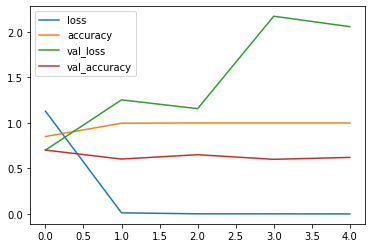

In [ ]:
pd.DataFrame(history.history).plot()

Learning curves are too bad

## **Plot some predictions with overfitted model**

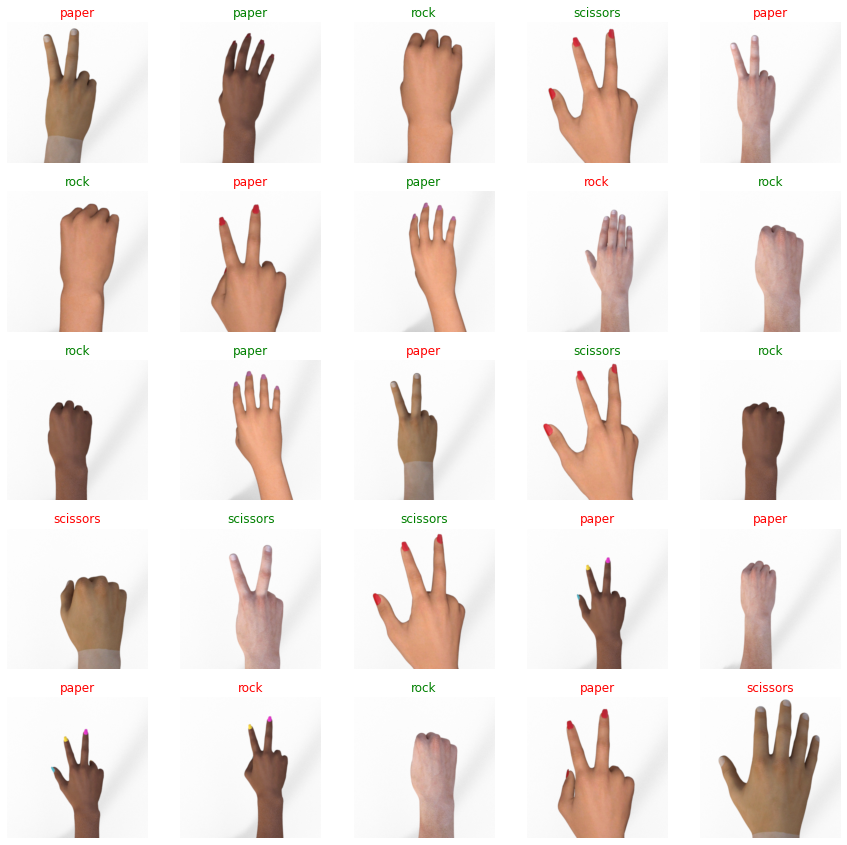

In [ ]:
plt.figure(figsize=(15, 15))

for i, datapoint in enumerate(test.take(25)):
  ax = plt.subplot(5, 5, i+1)
  plt.imshow(datapoint[0])
  image = resize_and_rescale(datapoint[0])
  image = np.expand_dims(image, axis = 0)

  if datapoint[1] == np.argmax(model.predict(image)):
    plt.title(class_names[np.argmax(model.predict(image))], color="green")
  else:
    plt.title(class_names[np.argmax(model.predict(image))], color="red")

  plt.axis("off")

plt.show()

OMG! More than 10 images are wrong preditions out of 25 images

We will solve this problem in my next session, please watch next video